<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LGBMClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [10]:
!pip install lightgbm

In [11]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize 
nltk.download('wordnet','stopwords','punkt','averaged_perceptron_tagger')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score

from sklearn.utils import shuffle


import warnings
warnings.filterwarnings('ignore')

In [12]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('C:/Users/ven89/OneDrive/Desktop/Кожемякина/toxic_comments.csv', index_col=0)
    

In [13]:
# общая информация
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [14]:
# посмотрим первые строки
data.sample(5)

,text,toxic
9406,"""\n\nLanguage and Mind-set of a Popular 1950s ...",0
58439,Thank you\nFor your taking the time and effort...,0
85585,"Yep, David section shall be reviewed, prolly w...",0
72583,"""\n{| style=""""background-color:#F5FFFA; paddin...",0
122409,", don't try to give the japanese credit for ev...",0


In [15]:
print('Количество пропущенных значений', data.isna().sum().sum())

Количество пропущенных значений 0


In [16]:
# функция, которая очистит текс от лишних символов
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = ' '.join(text.split())
    return text

In [17]:
# добавляю столбец с очищенным текстом
data['lemm_text'] = data['text'].apply(clear_text)
# проверка
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


In [18]:
# для того, чтобы лемматизировать, нужно создать экземпляр WordNetLemmatizer()
lemmatizer = WordNetLemmatizer()

In [19]:
# ввожу функцию РОS-тэгирования слов:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }  
    return tag_dict.get(tag, wordnet.NOUN)

In [22]:
#ввожу функцию леммализации тектов постов:
def lemm_text(text):
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text)

In [23]:
%%time
# лемматизирую текст
data['lemm_text'] = data['lemm_text'].apply(lemm_text)

CPU times: total: 56min 6s
Wall time: 56min 6s


In [24]:
# проверка
data['lemm_text'][0]

'explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now'

In [25]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ven89\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ven89\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ven89\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [26]:
# cделаем стоп-слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ven89\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


In [28]:
text = data['lemm_text']
print(type(text))

<class 'pandas.core.series.Series'>


In [29]:
# посмотрим, какие слова встречаются чаще всего
from nltk.probability import FreqDist

fdist = FreqDist(text)
fdist.most_common(5)

[('january', 21),
 ('thank you for experiment with wikipedia your test work and it have be revert or remove please use the sandbox for any other test you may want to do take a look at the welcome page to learn more about contribute to our encyclopedia talk',
  19),
 ('jun utc', 18),
 ('please stop if you continue to vandalize page you will be block from edit wikipedia',
  18),
 ('precede unsigned comment add by', 16)]

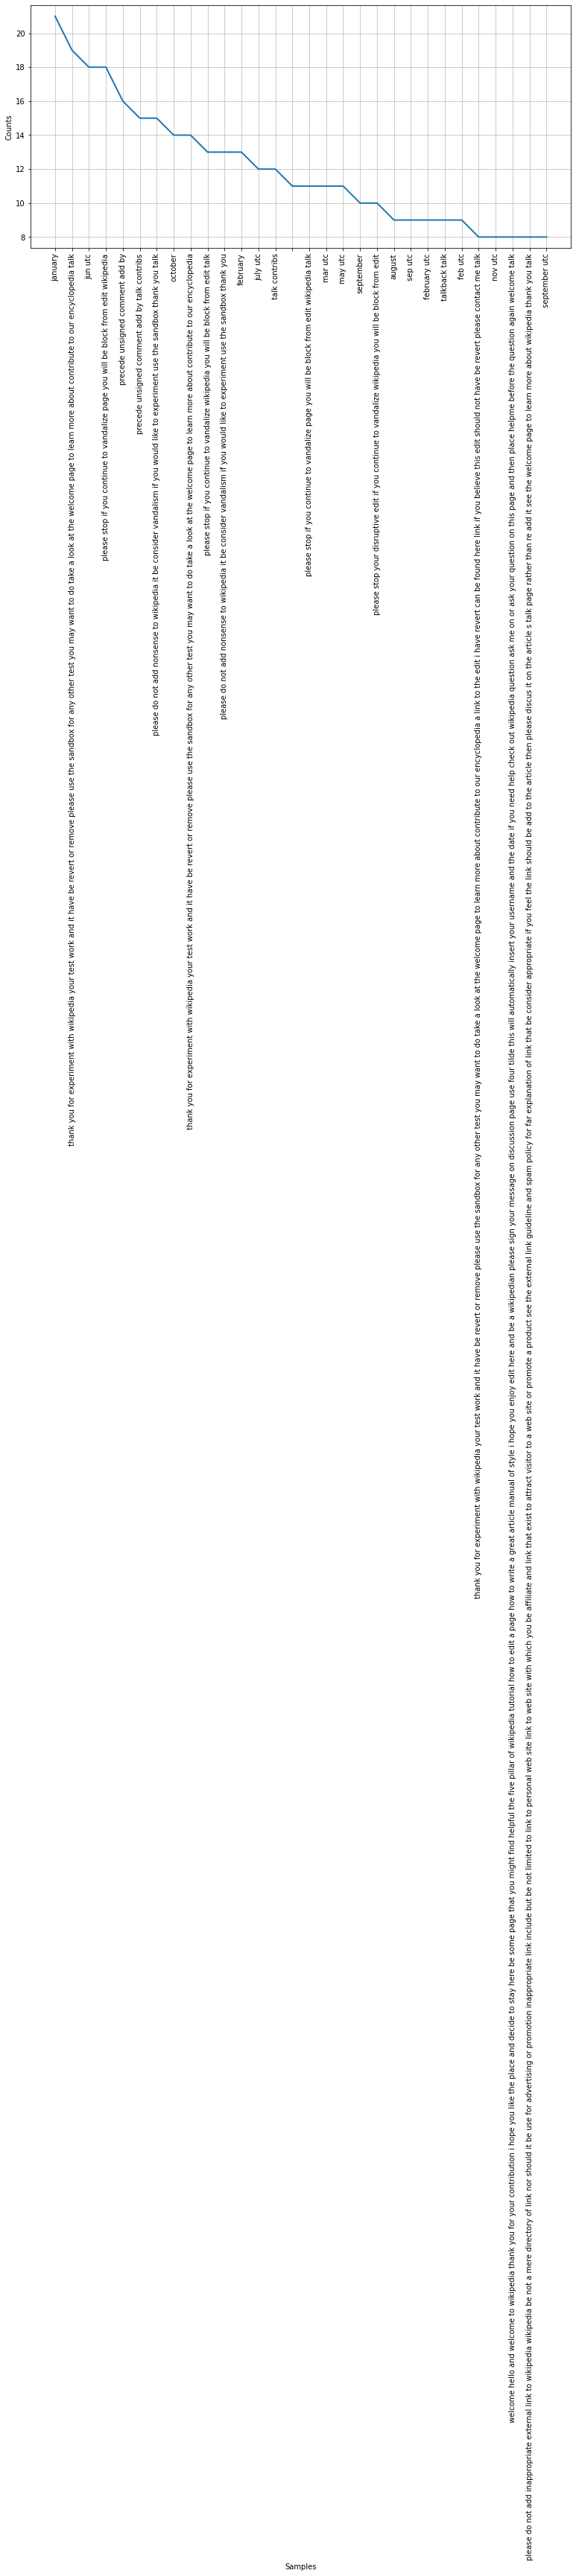

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [30]:
plt.figure(figsize=(13, 6))
fdist.plot(30,cumulative=False)

0    143106
1     16186
Name: toxic, dtype: int64
Распределение комментариев: 0.11


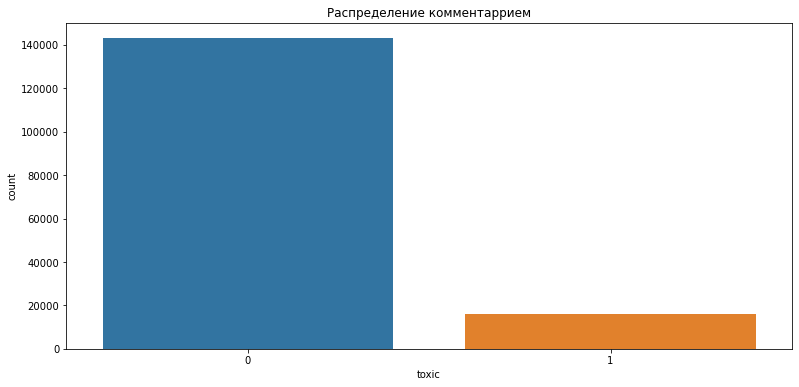

In [31]:
# посмотрик как распределены комментарии
print(data['toxic'].value_counts());
print('Распределение комментариев:', round(data['toxic'].value_counts()[1]/data['toxic'].value_counts()[0], 2))


plt.figure(figsize=(13, 6))
sns.countplot(x='toxic', data=data);
plt.title('Распределение комментаррием');

В данных наблюдается дисбаланс классов, токсичных комментарий всего 11%. Необходимо учесть это при построении моделей. К балансировке методами upsample и downsamle решила не прибегать, так как, на мой взгляд, искуственная балансировка не отражает действительности и может завышать результат, поэтому пропорции негативных комментариев решила сохранить

In [32]:
# объявляем признаки и целевой признак
features = data['lemm_text']
target = data['toxic']

In [33]:
# делим на обучающую и тестовую выборки учитывая дисбаланс
features_train_1, features_test_1, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify = target)

In [34]:
# проверка
print(target_train.value_counts()[1]/target_train.value_counts()[0])
print(target_test.value_counts()[1]/target_test.value_counts()[0])

0.11311015662123004
0.11308941498728234


In [35]:
# cделаем стоп-слова и векторизацию текста
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
#count_tf_idf = TfidfVectorizer(stop_words=stopwords)
#features_train = count_tf_idf.fit_transform(features_train_1)
#features_test = count_tf_idf.transform(features_test_1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ven89\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# проверка
print(features_train_1.shape)
print(features_test_1.shape)
print(target_train.shape)
print(target_test.shape)

(119469,)
(39823,)
(119469,)
(39823,)


## Обучение

В качестве моделей будем использовать Логистическую регрессию и LGBMClassifier с учетом балансировки классов.

### Логистическая регрессия

In [37]:
# посчитала folds
from sklearn.model_selection import KFold
folds = KFold(n_splits=8,  shuffle=True, random_state=12345)

In [38]:
%%time

# подбор гиперпараметров:
pipeline = Pipeline([("vect", TfidfVectorizer(stop_words='english', sublinear_tf=True)), 
                     ("lr", LogisticRegression())])
    
parameters = {'lr__C': (.1, 1, 5, 10),
              'lr__random_state': ([12345]),
              'lr__max_iter': ([200]),
              'lr__class_weight': (['balanced'])} 
gscv = GridSearchCV(pipeline, parameters, scoring='f1', cv=3, n_jobs=-1)

gscv.fit(features_train_1, target_train)

f1_lr_cv = gscv.best_score_
print('Качество модели Логистической регрессии на кросс-валидации:', round(f1_lr_cv,2))
print('при параметрах', gscv.best_params_)


Качество модели Логистической регрессии на кросс-валидации: 0.76
при параметрах {'lr__C': 5, 'lr__class_weight': 'balanced', 'lr__max_iter': 200, 'lr__random_state': 12345}
CPU times: total: 23.4 s
Wall time: 24.6 s


### LGBMClassifier

In [43]:
%%time

lgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), stop_words=stopwords, min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1)),
    ('clf', LGBMClassifier(random_state=12345))])

params = {
  'clf__num_leaves': [5, 10, 15, 20, 25, 31, 35],
  'clf__class_weight': (['balanced'])
  #'clf__learning_rate': [0.15, 0.25],
  #'clf__max_depth': [5, 8, 10]
}

lgb_grid = GridSearchCV(estimator=lgb_pipe, param_grid=params, cv=folds, scoring='f1', n_jobs=-1, refit=False)
lgb_grid.fit(features_train_1, target_train)
lgb_best_params = lgb_grid.best_params_
f1_lgb_cv = lgb_grid.best_score_
print(lgb_best_params)
print('Качество модели LGBMClassifier на кросс-валидации:', lgb_grid.best_score_)

{'clf__class_weight': 'balanced', 'clf__num_leaves': 35}
Качество модели LGBMClassifier на кросс-валидации: 0.7308552788243415
CPU times: total: 13.4 s
Wall time: 13min 41s


На кросс-валидации лучшей моделью стала Логистическая регрессия. Проверим эти модели на обучающей выборке.

In [44]:
# cделаем векторизацию текста
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
features_train = count_tf_idf.fit_transform(features_train_1)
features_test = count_tf_idf.transform(features_test_1)

Наилучшей моделью на кросс-валидации является Логистическая регрессия с f1=0.77 проверим ее на тестовых данных:

In [51]:
# предсказания  модели Логистической регрессии на тестовых данных
model_lr = LogisticRegression(class_weight='balanced', 
                                random_state=12345,
                                C=5,
                                max_iter=200
                               )

model_lr.fit(features_train, target_train)
pred_lr_test = model_lr.predict(features_test)
f1_lr_test = f1_score(target_test, pred_lr_test)
print('Качество модели Логистической регрессии на обучающей выборке:', f1_lr_test)

Качество модели Логистической регрессии на обучающей выборке: 0.7577807848443843


## Выводы

Нашей целью было найти и обучить модель для магазина "Викишоп", которая способна классифицировать комментарии на позитивные и негативные для того, чтобы в дальнейшем токсичные отзывы отправлялись на модерацию. При этом достигуть результата предсказания наилучшей модели по мерке F1 не меньше 0.75.

Перед обучением модели комментарии были очищены от лишних симполов. При проверке распределения классов былыло обнаружено, что негативных комментарием всего 11%. К балансировке методами upsample и downsamle решила не прибегать, так как, на мой взгляд, искуственная балансировка не отражает действительности и может завышать результат, поэтому пропорции негативных комментариев были сохранены.

Для определения наилучшей модели были использованы модели LogisticRegression и LGBMClassifier. По итогам сравнеиня победила модель LogisticRegression с метрикой на тестовых данных F1=0.75.

Таким образом, для магазина "Викишоп" можно рекомендовать модель LogisticRegression.
